# Markov Regime Switching Regression Model
_______

### In probability theory, a Markov model is a stochastic model used to model pseudo-randomly changing systems. It is assumed that future states depend only on the current state, not on the events that occurred before it. 
#### Source:[Wikipedia](https://en.wikipedia.org/wiki/Markov_model#Introduction)
__________

### The purpose of regime shifts prediction is to account for so called [Black Swan](https://www.investopedia.com/terms/b/blackswan.asp#:~:text=A%20black%20swan%20is%20an,they%20were%20obvious%20in%20hindsight.) events, that happen more frequently than normal distribution probability would lead us to believe. 


Source:

https://www.statsmodels.org/stable/generated/statsmodels.tsa.regime_switching.markov_regression.MarkovRegression.html

https://www.statsmodels.org/devel/examples/notebooks/generated/markov_regression.html


In [1]:
# Import libraries
import numpy as np
import datetime
import warnings
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.regime_switching import markov_regression

%matplotlib inline

# Predicting the market volatility and Markov regime shifts using VXX ETF as a proxy for market volatility

In [27]:
# Read in VIX price (Adj Close) data from csv file (Adj Close prices pulled from the yahoo_historical.ipynb)
vix_prices = pd.read_csv("../Resources/stock_historical_prices.csv", parse_dates=True, index_col='Date')
vix_prices = stock_prices.resample('W').ffill()
#We will use weekly returns from 2018-2021
vix_prices = vix_prices.loc['2018':'2021']
vix_prices = vix_prices.dropna()
vix_prices.head()

,Adj Close,Return,Predicted
Date,,,
2018-01-21,264.252472,0.008959,0.002969
2018-01-28,270.066925,0.022003,0.005290
2018-02-04,259.578278,-0.038837,-0.015554
2018-02-11,246.432068,-0.050644,-0.058562
2018-02-18,257.373077,0.044398,0.022904


In [28]:
# Calculate weekly return
vix_prices["Return"] = vix_prices['Adj Close'].pct_change()
vix_return = vix_prices["Return"]
vix_return = vix_return.asfreq('W')
vix_return = vix_return.dropna()
vix_return.head()

Date
2018-01-28    0.022003
2018-02-04   -0.038837
2018-02-11   -0.050644
2018-02-18    0.044398
2018-02-25    0.005859
Freq: W-SUN, Name: Return, dtype: float64

<AxesSubplot:title={'center':'VXX Weekly Returns'}, xlabel='Date'>

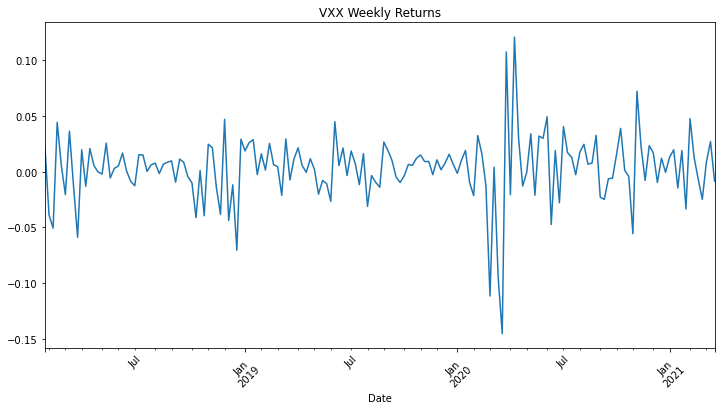

In [29]:
# Plot weekly returns
vix_return.plot(title='VXX Weekly Returns',figsize=(12,6),rot=45)

In [30]:
# Apply the Augmented Dickey-Fuller test to determine if the above is stationary
adfuller(vix_return)

(-14.199295081253073,
 1.799494725600298e-26,
 0,
 164,
 {'1%': -3.47086589632514, '5%': -2.879330279087651, '10%': -2.57625492712671},
 -623.0375657716545)

In [31]:
# Fit the model to include lagged return data
mod_high_regime = sm.tsa.MarkovRegression(vix_return.iloc[1:],k_regimes=2, freq='W', exog=vix_return.iloc[:-1])
res_high_regime = mod_high_regime.fit()
res_high_regime.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Markov Switching Model Results                        
==============================================================================
Dep. Variable:                 Return   No. Observations:                  164
Model:               MarkovRegression   Log Likelihood                 367.544
Date:                Wed, 07 Jul 2021   AIC                           -721.088
Time:                        23:32:09   BIC                           -699.389
Sample:                    02-04-2018   HQIC                          -712.279
                         - 03-21-2021                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0586      0.013     -4.626      0.000      -0.083      -0.034
x1             0.8043      0.171      4.690      0.000       0.468       1.140
                             Regime 1 parameters                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0078      0.002      3.859      0.000       0.004       0.012
x1            -0.2959      0.076     -3.876      0.000      -0.446      -0.146
                           Non-switching parameters                           
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0005   6.68e-05      7.327      0.000       0.000       0.001
                         Regime transition parameters                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p[0->0]        0.1761      0.152      1.158      0.247      -0.122       0.474
p[1->0]        0.0541      0.031      1.762      0.078      -0.006       0.114
==============================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [66]:
print(res_high_regime.expected_durations)

[ 1.21370735 18.50019366]


In [67]:
# Duration suggests that low regime will persist for approx 1 week and high regime for 19 weeks suggesting an extended timeframe of high market volatility. Similar result as with lagged SPY model. We also need to keep in mind that VIX ETFs are not a perfect proxy for VIX fear index and they (ETFs that trade VIX) are volatilie in nature because of the way they operate. Need to evaluate more. 

<AxesSubplot:title={'center':'Probability of being in the high regime'}, xlabel='Date'>

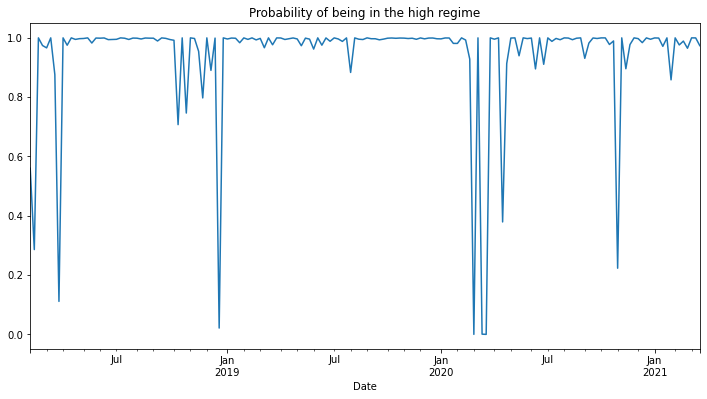

In [32]:
res_high_regime.smoothed_marginal_probabilities[1].plot(
    title='Probability of being in the high regime', figsize=(12,6))

In [33]:
prediction = res_high_regime.predict()

/Users/bogica/miniforge3/envs/tf_m1/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


In [34]:
# Add predicted weekly return to dataframe
vix_prices["Return"] = vix_prices['Adj Close'].pct_change()
vix_prices['Predicted'] = prediction
vix_prices.dropna()

,Adj Close,Return,Predicted
Date,,,
2018-02-04,259.578278,-0.038837,-0.017245
2018-02-11,246.432068,-0.050644,-0.058609
2018-02-18,257.373077,0.044398,0.022791
2018-02-25,258.880920,0.005859,-0.005784
2018-03-04,253.575333,-0.020494,0.004048
...,...,...,...
2021-02-21,388.756714,-0.006647,0.003472
2021-02-28,379.118286,-0.024793,0.007193
2021-03-07,382.377625,0.008597,0.015139


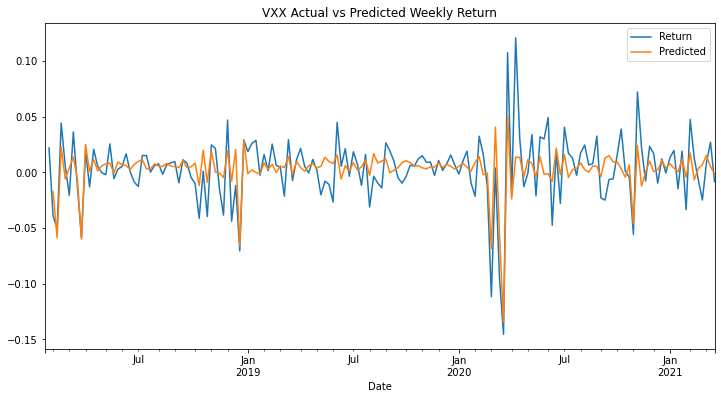

In [35]:
combined = vix_prices[['Return','Predicted']].plot(title='VXX Actual vs Predicted Weekly Return', figsize=(12,6))

In [36]:
vix_prices.describe()

,Adj Close,Return,Predicted
count,166.000000,165.000000,164.000000
mean,293.416900,0.002813,0.002696
std,39.464609,0.030147,0.018592
min,225.188736,-0.145457,-0.134657
25%,263.467842,-0.009499,0.000239
50%,282.376923,0.005704,0.005226
75%,316.880501,0.018635,0.009431
max,392.773560,0.120915,0.050847


<AxesSubplot:ylabel='Frequency'>

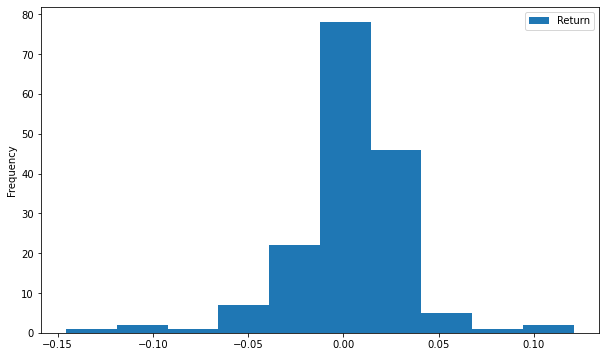

In [37]:
vix_prices[['Return']].plot(kind='hist', figsize=(10,6))

In [38]:
mean = vix_prices['Return'].mean()
std = vix_prices['Return'].std()
(mean, std)

(0.002812823913928339, 0.030146965520910535)

In [39]:
gauss(mean, std)

0.03867897353754077

<AxesSubplot:ylabel='Frequency'>

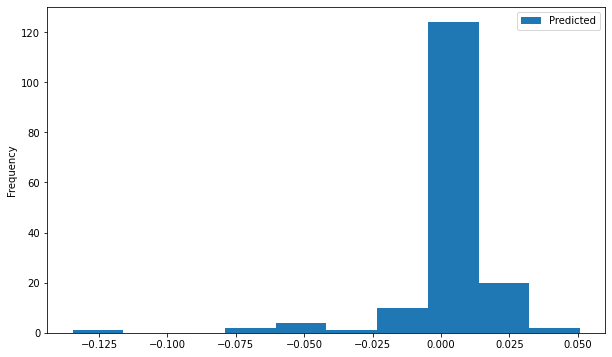

In [40]:
vix_prices[['Predicted']].plot(kind='hist', figsize=(10,6))

In [41]:
mean = vix_prices['Predicted'].mean()
std = vix_prices['Predicted'].std()
(mean, std)

(0.0026958090635560467, 0.01859161291088712)

In [42]:
gauss(mean, std)

0.03233642318430994

In [79]:
# VIX ETF predicted values exhibit non-normal distribution with left tail outliiers. 